In [ ]:
## TODO: add negative datapoints

In [ ]:
import json
from PIL import Image
import cv2

import tensorflow as tf

import pandas as pd
from collections import OrderedDict
import random
#import ignite

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from itertools import chain
from PIL.Image import BICUBIC
from collections import OrderedDict
import math

from tqdm import tqdm

## Download Data

In [ ]:
import os
from google.colab import drive

drive.mount('/gdrive',force_remount=True)
if not os.path.isdir('/content/img_cut'):
  %cp -r /gdrive/MyDrive/img_cut /content/

Mounted at /gdrive


## Check object size distributions

- useful for choosing the right neural net classifier

In [ ]:
sizes = []
for root, dir, files in os.walk("/content/img_cut/img/"):
  for i in files:
    img = Image.open("/content/img_cut/img/"+i)
    sizes.append(img.size)


def histoplotter(x, y, range_):
  # Plotter
  # CITATION: Ryan Dorrill 2018

  fig = plt.figure()          #create a canvas
  ax = fig.add_subplot(111, projection='3d')

  # histogram 
  hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20),range = [[0,range_],[0,range_]],)
  xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

  xpos = xpos.flatten()/2.
  ypos = ypos.flatten()/2.
  zpos = np.zeros_like (xpos)

  dx = xedges [1] - xedges [0]
  dy = yedges [1] - yedges [0]
  dz = hist.flatten()

  cmap = cm.get_cmap('jet') 
  max_height = np.max(dz)   
  min_height = np.min(dz)
  # scale each z to [0,1], and get their rgb values
  rgba = [cmap((k-min_height)/max_height) for k in dz] 

  ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
  plt.title("object size histogram")
  plt.xlabel("Width")
  plt.ylabel("Height")
  #plt.savefig("")
  plt.show()


<ipython-input-4-f5bda08c34a1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


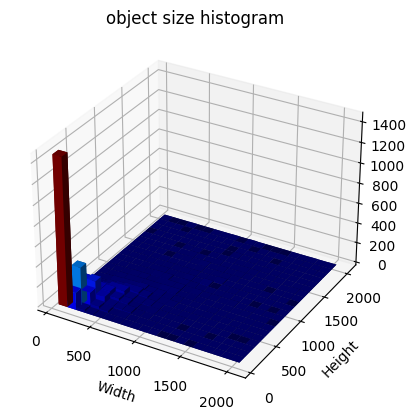

In [ ]:
xAmplitudes = [i[0] for i in sizes]
yAmplitudes = [i[1] for i in sizes]
histoplotter(xAmplitudes,yAmplitudes,2000)

<ipython-input-4-f5bda08c34a1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


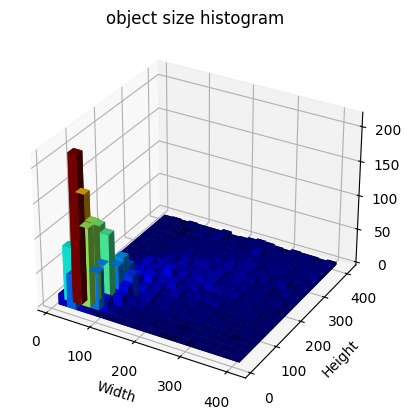

In [ ]:
histoplotter(xAmplitudes,yAmplitudes,400)

## Data

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv
mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}

In [ ]:
# define number of classes
# can be changed depending on our future model designs
NR_CLASSES = 5

### padding to square

although computer vision applications are versatile, the models behind are usually trained on square images. 

input images generated by SAM are non-square, we pad to make them square. 

we use padding not cutting due to the intention to maintain information in each image.

In [ ]:
def padding(image):
  return tf.image.resize_with_pad(
    image,
    224,
    224,
    method = tf.image.ResizeMethod.BICUBIC,
    antialias=False)
  

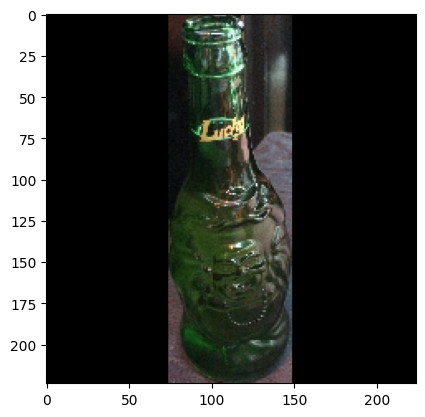

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = './img_cut/img/0_1.jpg'
img = image.load_img(img_path)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

x = padding(x)

plt.imshow(x[0]/255)

### Data augmentation

currently only flip and rotation is implemented; 
looking forward to team's work on augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1),]
)

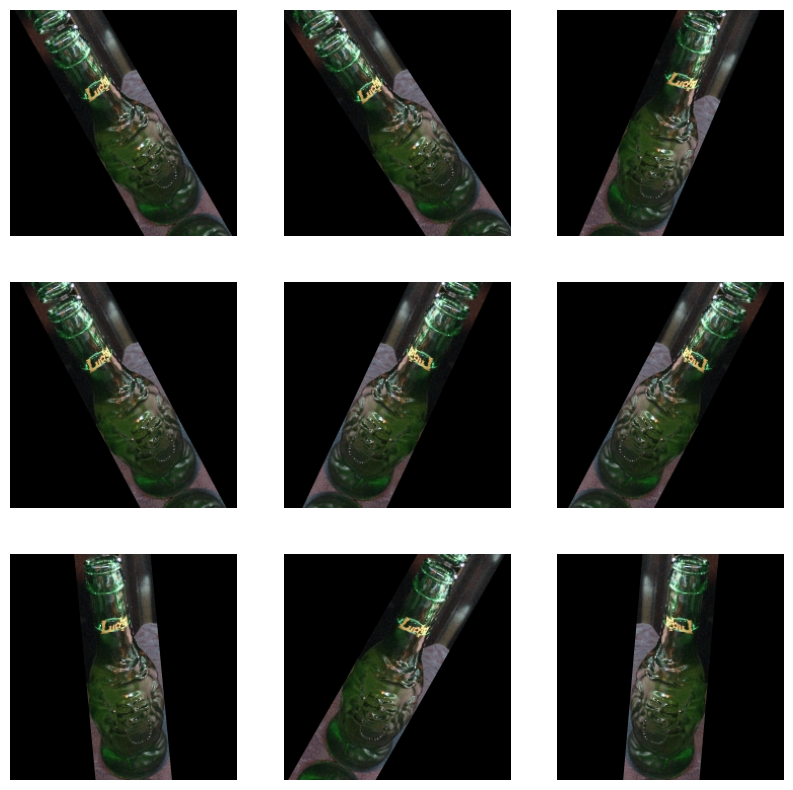

In [ ]:
# example visualization of augmentation
import numpy as np

plt.figure(figsize=(10, 10))
first_image = tf.convert_to_tensor(x)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        first_image, training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")


### TF specific Data Pipeline

In [ ]:
%%capture 
# get train test split; split has been done in another script.
!wget https://github.com/running-man-01/utilities/raw/main/TACO_trte_split.npz

In [ ]:
# return data file name and label


import re
def TACO_label_getter(data_split=None):
  train_test_ids = np.load('/content/TACO_trte_split.npz') 
  if data_split == 'train': 
    img_ids = train_test_ids['train'].tolist()
  elif data_split == 'test': 
    img_ids = train_test_ids['test'].tolist()
  elif data_split == 'val': 
    img_ids = train_test_ids['val'].tolist()

  for _,_,files in os.walk('/content/img_cut/lbl/'):
    cache = []
    for i in files: #tqdm(files):
      if int(re.split('_',i)[0]) not in img_ids:
        pass
      else:
        cache1 = np.load('/content/img_cut/lbl/'+str(i),allow_pickle=True)
        cache1 = cache1['arr_0'].tolist()['category_id']
        cache1 = str(mkey_dict[cache1])
        cache.append([str(i).replace('npz','jpg'),cache1])

  return cache


In [ ]:
train_test_ids = np.load('/content/TACO_trte_split.npz') ##TODO: change to generic location
path = '/content/img_cut/img/'

train_ids = TACO_label_getter('train')
val_ids = TACO_label_getter('val')
test_ids = TACO_label_getter('test')

train_files = [[os.path.join(path, str(i[0])),i[1]] for i in train_ids] 
val_files = [[os.path.join(path, str(i[0])),i[1]] for i in val_ids]
test_files = [[os.path.join(path, str(i[0])),i[1]] for i in test_ids]


In [ ]:
# mapping label classes; 
# one-hot labels
def read_image(filepair):
    f = tf.io.read_file(filepair[0]) 
    lbl = int(filepair[1])
    lbl = tf.one_hot(lbl,NR_CLASSES)
    image = tf.image.decode_image(f)
    image = padding(image)
    return image,lbl

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(read_image,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(read_image,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(read_image,num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [ ]:
#check sizes of images and labels in each batch
for i in train_dataset:
  print(i[0].shape)
  print(i[1].shape)
  break

(16, 224, 224, 3)
(16, 5)


## Build EfficientNet-based classification Model


In [ ]:
#Get pretrained EfficientNetV2; trained on imagenet
efficientnet = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    weights='imagenet',
    input_shape=[224,224,3],
    pooling=None,
    include_preprocessing=False,
    include_top=False
)

In [ ]:
efficientnet.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                 

### freeze pre-trained layers 

In [ ]:
efficientnet.trainable = True

### add customized classification layers

In [ ]:
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)


In [ ]:
# Create model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  
x = scale_layer(x)

 # Efficient Net Base Model
x = efficientnet(x, training=False) 

 # customized classification layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(NR_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

## Train

In [ ]:
model.compile(optimizer=
              tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(train_dataset,
          epochs=10,
          verbose=1,
          validation_data=val_dataset)

Epoch 1/10
220/220 [==============================] - 73s 83ms/step - loss: 1.1974 - categorical_accuracy: 0.5504 - val_loss: 1.1267 - val_categorical_accuracy: 0.5839
Epoch 2/10
220/220 [==============================] - 16s 67ms/step - loss: 0.9831 - categorical_accuracy: 0.6416 - val_loss: 1.0140 - val_categorical_accuracy: 0.6369
Epoch 3/10
220/220 [==============================] - 16s 66ms/step - loss: 0.8709 - categorical_accuracy: 0.6798 - val_loss: 0.9576 - val_categorical_accuracy: 0.6515
Epoch 4/10
220/220 [==============================] - 16s 66ms/step - loss: 0.7905 - categorical_accuracy: 0.7031 - val_loss: 0.9195 - val_categorical_accuracy: 0.6606
Epoch 5/10
220/220 [==============================] - 16s 68ms/step - loss: 0.7202 - categorical_accuracy: 0.7368 - val_loss: 0.9117 - val_categorical_accuracy: 0.6734
Epoch 6/10
220/220 [==============================] - 16s 66ms/step - loss: 0.6501 - categorical_accuracy: 0.7575 - val_loss: 0.8757 - val_categorical_accuracy: